[Link to Page](https://tutorials.pytorch.kr/beginner/blitz/cifar10_tutorial.html)

# Load Data

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
# load dataset
transform = transforms.Compose( [transforms.ToTensor(), transforms.Normalize( (0.5, 0.5, 0.5), (0.5,0.5,0.5))])

trainset = torchvision.datasets.CIFAR10(root ='./data', train = True, download = True, transform = transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size = 4, shuffle = True, num_workers = 2)

testset = torchvision.datasets.CIFAR10(root = './data', train = False, download = True, transform = transform)

testloader = torch.utils.data.DataLoader(testset, batch_size = 4, shuffle = False, num_workers = 2)

classes = ('plane','car','bird','cat','deer','dog','frog','horse','ship','truck')

Files already downloaded and verified
Files already downloaded and verified


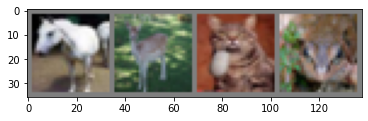

horse  deer   cat  frog


In [3]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    #plt.figure(figsize = (20,12))
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

# 학습용 이미지 무작위로
dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))

print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [4]:
images.size()

torch.Size([4, 3, 32, 32])

# CNN

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) # 32 - 5 + 1 = 28
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5) # 14 -5 + 1 = 10
        # pooling
        self.fc1 = nn.Linear(16 * 5 * 5, 120) # 4 * 16 * 5 * 5
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 *5 *5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = Net()
        

# Loss & Optimizer

In [6]:
import torch.optim as optim

criterian = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = 0.001, momentum = 0.9)

# Training

In [7]:
for epoch in range(2):
    running_loss = 0.
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        outputs = net(inputs)
        
        optimizer.zero_grad()
        loss = criterian(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
print('Finished Training')        

[1,  2000] loss: 2.253
[1,  4000] loss: 1.862
[1,  6000] loss: 1.662
[1,  8000] loss: 1.581
[1, 10000] loss: 1.510
[1, 12000] loss: 1.467
[2,  2000] loss: 1.403
[2,  4000] loss: 1.392
[2,  6000] loss: 1.360
[2,  8000] loss: 1.336
[2, 10000] loss: 1.319
[2, 12000] loss: 1.297
Finished Training


In [8]:
# save model

PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

# Test

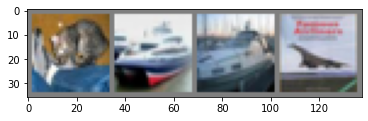

Ground Truth :   cat  ship  ship plane


In [9]:
dataiter = iter(testloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print("Ground Truth :",' '.join("%5s"%classes[labels[k]] for k in range(4)))


In [10]:
# load model
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [11]:
# predict 1st mini-batch
outputs = net(images)

In [12]:
_, predicted = torch.max(outputs, axis = 1)
print("Predicted :",' '.join("%5s"%classes[predicted[j]] for j in range(4)))

Predicted :   cat  ship   car plane


In [13]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print("Acc of 10000 test images : %d %%"%(100 * correct / total))

Acc of 10000 test images : 55 %


In [14]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, axis = 1)
        c = (predicted == labels).squeeze()
        #print(c)
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
for i in range(10):
    print("Acc of %5s : %2d %%"%(classes[i], 100*class_correct[i]/class_total[i]))

Acc of plane : 69 %
Acc of   car : 71 %
Acc of  bird : 30 %
Acc of   cat : 37 %
Acc of  deer : 47 %
Acc of   dog : 53 %
Acc of  frog : 71 %
Acc of horse : 62 %
Acc of  ship : 57 %
Acc of truck : 56 %


# With GPU

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# CUDA 기기가 존재한다면, 아래 코드가 CUDA 장치를 출력합니다:

print(device)

cpu


In [16]:
# Network를 GPU로
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [17]:
# 각 단계에서 input, target 또한 GPU로
inputs, labels = data[0].to(device), data[1].to(device)